In [1]:
from datetime import datetime, timedelta
import time

import requests, pandas, lxml
from lxml import html

import numpy as np
import matplotlib.pyplot as plt

import talib as ta

In [172]:
plt.rcParams["figure.figsize"] = (12,4)

In [2]:
def format_date(date_datetime):
    date_timetuple = date_datetime.timetuple()
    date_mktime = time.mktime(date_timetuple)
    date_int = int(date_mktime)
    date_str = str(date_int)
    return date_str


def subdomain(symbol, start, end, filter='history'):
    subdoma="/quote/{0}/history?period1={1}&period2={2}&interval=1d&filter={3}&frequency=1d"
    subdomain = subdoma.format(symbol, start, end, filter)
    return subdomain


def header_function(subdomain):
    hdrs = {"authority": "finance.yahoo.com",
            "method": "GET",
            "path": subdomain,
            "scheme": "https",
            "accept": "text/html",
            "accept-encoding": "gzip, deflate, br",
            "accept-language": "en-US,en;q=0.9",
            "cache-control": "no-cache",
            "dnt": "1",
            "pragma": "no-cache",
            "sec-fetch-mode": "navigate",
            "sec-fetch-site": "same-origin",
            "sec-fetch-user": "?1",
            "upgrade-insecure-requests": "1",
            "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64)"}
    return hdrs


def scrape_page(url, header):
    page = requests.get(url, headers=header)
    element_html = html.fromstring(page.content)
    table = element_html.xpath('//table')
    table_tree = lxml.etree.tostring(table[0], method='xml')
    panda = pandas.read_html(table_tree)
    return panda

In [161]:
def get_stock(symbol = 'GOOG', days=365):
    dt_start = datetime.today() - timedelta(days=days)
    dt_end = datetime.today()

    start = format_date(dt_start)
    end = format_date(dt_end)

    sub = subdomain(symbol, start, end)
    header = header_function(sub)

    base_url = 'https://finance.yahoo.com'
    url = base_url + sub
    price_history = scrape_page(url, header)
    
    return price_history[0]


def get_close_price(price_df, days=100):
    close_price_ls = list(price_df['Close*'][0:days])
    for item in close_price_ls:
        if 'Dividend' in item:
            close_price_ls.remove(item)
            
    close_price = np.flip(np.array(close_price_ls).astype('float'))
    return close_price


def get_high_price(price_df, days=100):
    high_price_ls = list(price_df['High'][0:days])
    for item in high_price_ls:
        if 'Dividend' in item:
            high_price_ls.remove(item)
            
    high_price = np.flip(np.array(high_price_ls).astype('float'))
    return high_price


def get_low_price(price_df, days=100):
    low_price_ls = list(price_df['High'][0:days])
    for item in low_price_ls:
        if 'Dividend' in item:
            low_price_ls.remove(item)
            
    low_price = np.flip(np.array(low_price_ls).astype('float'))
    return low_price


In [5]:
price_history

[                                                  Date  \
 0                                         May 27, 2021   
 1                                         May 26, 2021   
 2                                         May 25, 2021   
 3                                         May 24, 2021   
 4                                         May 21, 2021   
 ..                                                 ...   
 96                                        Jan 08, 2021   
 97                                        Jan 07, 2021   
 98                                        Jan 06, 2021   
 99                                        Jan 05, 2021   
 100  *Close price adjusted for splits.**Adjusted cl...   
 
                                                   Open  \
 0                                                 9.70   
 1                                                 8.79   
 2                                                 8.64   
 3                                                 8.5

In [42]:
price_df = price_history[0]

In [15]:
price_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close*', 'Adj Close**', 'Volume'], dtype='object')

In [67]:
#Get close price of each day
close_price = np.flip(np.array(price_df['Close*'][0:100]).astype('float'))
print(close_price)

KeyError: 'Close'

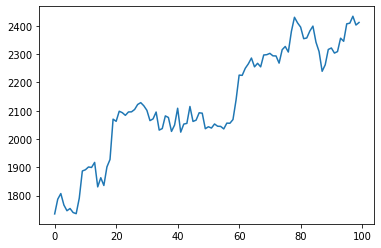

In [44]:
plt.plot(close_price)
plt.show()

In [7]:
def ta_SimpleMovingAverage(data, period=5, order='new2old'):
    if order=='old2new':
        data = np.flip(data)
    elif order=='new2old':
        pass
    else:
        print("Argumnent 'order' invalid")
        return None
    
    sma = []
    
    for i in range(0, len(data)-period+1):
        avg = np.mean(data[i:i+period])
        sma.append(avg)
        
    sma = np.array(sma)
    
    if order=='old2new':
        sma = np.flip(sma)
        
    return sma
    
    

In [8]:
period_N = 10
close_price_sma = ta_SimpleMovingAverage(close_price, period=period_N, order='old2new')

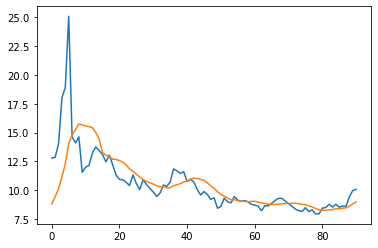

In [9]:
plt.plot(close_price[period_N-1:])
plt.plot(close_price_sma)
plt.show()

In [10]:
def ta_ExponentialMovingAverage(data, smooth=2.0, period=12, order='old2new'):
    if order=='new2old':
        data = np.flip(data)
    elif order=='old2new':
        pass
    else:
        print("Argumnent 'order' invalid")
        return None
    
    ema = []
    k = smooth/(1+period)
    eavg_y = np.mean(data[0:period])  #initial EMA
    
    for i in range(period, len(data)):
        eavg = data[i]*k + eavg_y*(1-k)
        eavg_y = eavg
        ema.append(eavg)
        
    ema = np.array(ema)
        
    if order=='new2old':
        ema = np.flip(ema)
    
    return ema


    

In [11]:
close_price_ema = ta_ExponentialMovingAverage(close_price, period=period_N)

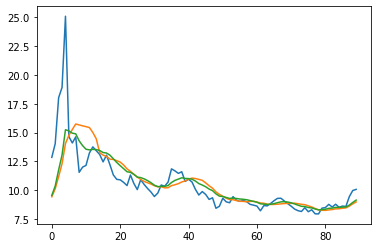

In [12]:
plt.plot(close_price[period_N:])
plt.plot(close_price_sma[1:])
plt.plot(close_price_ema)
plt.show()

In [13]:
def ta_MACD(data, order='old2new'):
    if order=='new2old':
        data = np.flip(data)
    elif order=='old2new':
        pass
    else:
        print("Argumnent 'order' invalid")
        return None
    
    ema_12 = ta_ExponentialMovingAverage(data, period=12)
    ema_26 = ta_ExponentialMovingAverage(data, period=26)
    macd = ema_12[14:] - ema_26
    
    if order=='new2old':
        macd = np.flip(macd)
        
    return macd, ema_12, ema_26
    
    

In [14]:
cp_macd, cp_ema_12, cp_ema_26  = ta_MACD(close_price)

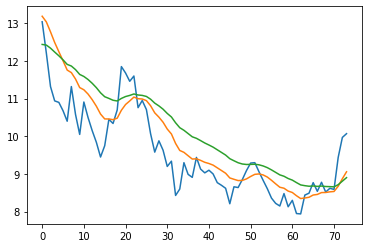

In [16]:
plt.plot(close_price[26:])
plt.plot(cp_ema_12[14:])
plt.plot(cp_ema_26)
plt.show()

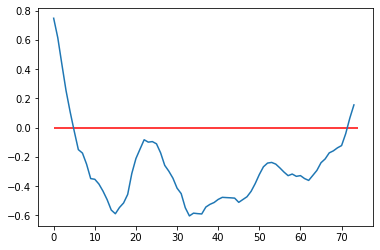

In [17]:
plt.hlines(0, 0, len(cp_macd), color='r')
plt.plot(cp_macd)
plt.show()

In [45]:
macd, macdsignal, macdhist = ta.MACD(close_price)

In [59]:
def plot_MACD(macd, macdsignel, macdhist):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 4))

    skip_nan = np.count_nonzero(np.isnan(macd))
    axes[0].hlines(0, skip_nan, len(macd), color='k', linewidth=1.0, label="baseline")
    axes[0].plot(macd, label="MACD")
    axes[0].plot(macdsignal, linestyle='dashed', label="Signal")
    axes[0].legend(loc="upper right")

    axes[1].hlines(0, skip_nan, len(macd), color='k')
    barlist = axes[1].bar(np.arange(len(macd)), macdhist, align='center', alpha=0.5)
    for i in range(len(macdhist)):
        if np.isnan(macdhist[i]):
            pass
        elif macdhist[i]>0:
            barlist[i].set_color('g')
        else:
            barlist[i].set_color('r')

    plt.show()
    

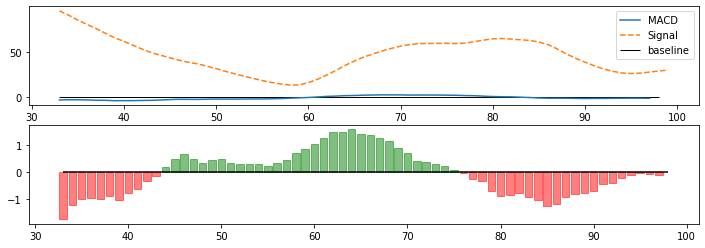

In [83]:
appl_df = get_stock(symbol="AAPL", days=365)
appl_cp = get_close_price(appl_df, days=100)
appl_macd, appl_macdsignal, appl_macdhist = ta.MACD(appl_cp)
plot_MACD(appl_macd, appl_macdsignal, appl_macdhist)

In [141]:
def find_trough_crest(data, diff_rate=0.05, day_filter_size=3):
    low = min(data)
    high = max(data)
    N = len(data)
    
    crest_cand = []
    trough_cand = []
    
    """
    if data[0]>data[1]:
        crest_cand.append(0)
    elif data[0]<data[1]:
        dip_cand.append(0)
    """
    
    #Scan for potential trough/crest
    for i in range(1, N-1):
        if data[i]<data[i-1] and data[i]<data[i+1]:
            trough_cand.append(i)
        elif data[i]>data[i-1] and data[i]>data[i+1]:
            crest_cand.append(i)

    
    trough_cond = low*(1+diff_rate)
    crest_cond = high*(1-diff_rate)
    #print(trough_cond, crest_cond)
    
    crest_filter1 = []
    trough_filter1 = []
    
    #1st filter: negligible amount
    for t in trough_cand:
        if data[t]<=trough_cond:
            trough_filter1.append(t)

    for c in crest_cand:
        if data[c]>=crest_cond:
            crest_filter1.append(c)
            
    
    crest_final = []
    trough_final = []
    
    #2nd filter: days filter
    for t in trough_filter1:
        lo = max(0,t-day_filter_size)
        up = min(N-1, t+day_filter_size)
        subset = data[lo:up+1]
        if len(subset)!=0:
            if min(subset)==data[t]:
                trough_final.append(t)
            
    for c in crest_filter1:
        lo = max(0,c-day_filter_size)
        up = min(N-1, c+day_filter_size)
        subset = data[lo:up+1]
        if len(subset)!=0:
            if max(subset)==data[c]:
                crest_final.append(c)
        
        
    return crest_final, trough_final
    #return crest_cand, trough_cand
    
        


def MACD_divergence(price, watch_window=5):
    macd, macdsignal, macdhist = ta.MACD(price)
    skip_nan = np.count_nonzero(np.isnan(macd))
    
    
        

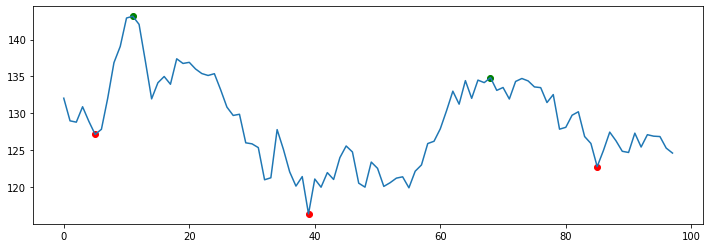

In [143]:
crest, trough = find_trough_crest(appl_cp, diff_rate=0.1, day_filter_size=18)
#print(crest)
#print(trough)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
plt.plot(appl_cp)

for c in crest:
    plt.scatter(c, appl_cp[c], color='g')
    
for t in trough:
    plt.scatter(t, appl_cp[t], color='r')

plt.show()



In [133]:
appl_cp[5]

127.14

In [ ]:
"""
[3, 11, 16, 18, 20, 24, 28, 34, 38, 40, 42, 45, 49, 54, 62, 64, 66, 68, 70, 73, 78, 82, 87, 91, 93]
[2, 5, 17, 23, 32, 39, 43, 51, 63, 67, 71, 79, 90]
"""

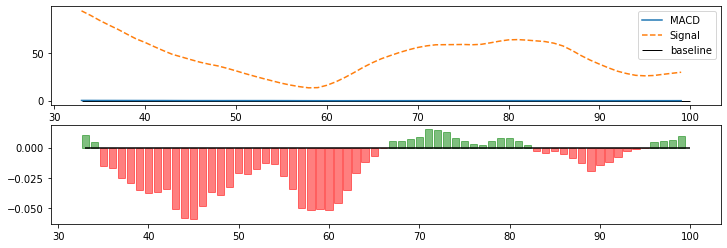

In [144]:
hk0546_df = get_stock(symbol="0546.HK", days=365)
hk0546_cp = get_close_price(hk0546_df, days=100)
hk0546_macd, hk0546_macdsignal, hk0546_macdhist = ta.MACD(hk0546_cp)
plot_MACD(hk0546_macd, hk0546_macdsignal, hk0546_macdhist)

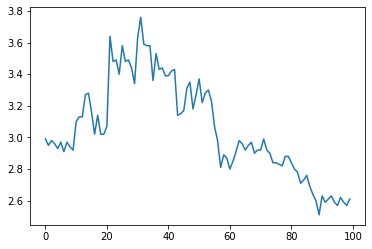

In [145]:
plt.plot(hk0546_cp)

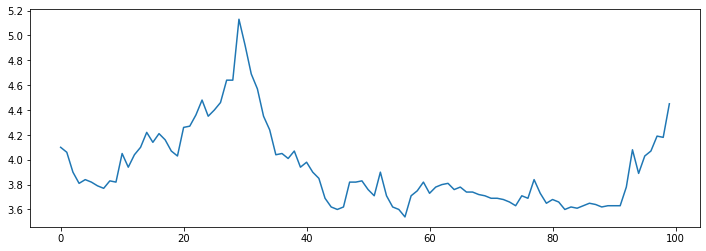

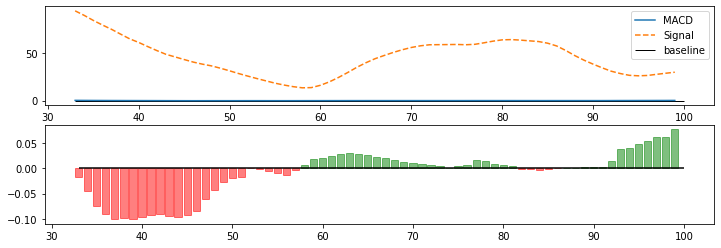

In [146]:
hk1119_df = get_stock(symbol="1119.HK", days=365)
hk1119_cp = get_close_price(hk1119_df, days=100)
hk1119_macd, hk1119_macdsignal, hk1119_macdhist = ta.MACD(hk1119_cp)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
plt.plot(hk1119_cp)
plot_MACD(hk1119_macd, hk1119_macdsignal, hk1119_macdhist)

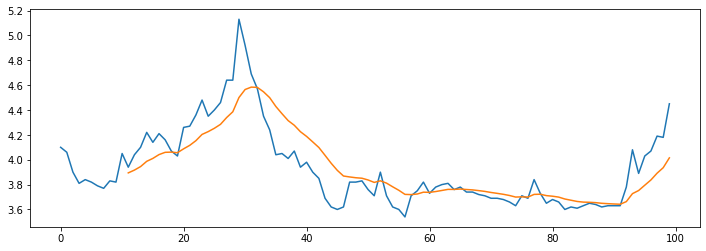

In [187]:
hk1119_ma = ta.EMA(hk1119_cp, timeperiod=12)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
plt.plot(hk1119_cp)
plt.plot(hk1119_ma)

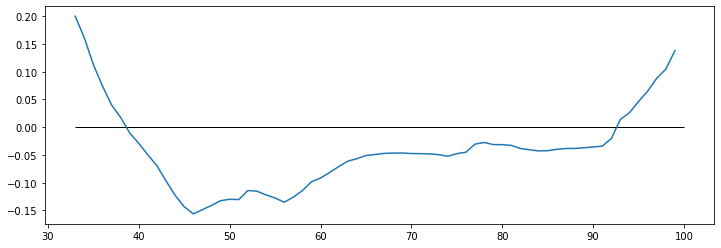

In [160]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
skip_nan = np.count_nonzero(np.isnan(hk1119_macd))
plt.plot(hk1119_macd)
plt.hlines(0, skip_nan, len(hk1119_macd), color='k', linewidth=1.0, label="baseline")

In [226]:
def compare_price_MACD(price, macd, ema_period=12, confid=0.8, min_day=5):
    N = len(macd)
    price_avg = ta.EMA(price, timeperiod=ema_period)
    pair_period = []
    pair_score = []
    pair_pattern = []
    
    for n in range(1, N-min_day):
        K = n+min_day
        
        if K>=N:
            pass
        else:
            
            while K<N:
                
                match = []
                for i in range(n, K):
                    if np.isnan(macd[i-1]) or np.isnan(price_avg[i-1]):
                        pass
                    else:
                        macd_dir = macd[i]>macd[i-1]
                        price_dir = price_avg[i]>price_avg[i-1]
                        div = macd_dir!=price_dir
                        match.append(int(div))
                        
                if len(match)>min_day:
                    match_score = float(np.sum(np.array(match)))/len(match)
                    #print(match_score)
                    pair_period.append((n,K-1))
                    pair_score.append(match_score)
                    pair_pattern.append(match.copy())
                
                K+=1

    max_index = pair_score.index(max(pair_score))
    
    return pair_period[max_index], pair_score[max_index], pair_pattern[max_index]

In [227]:
period, score, pattern = compare_price_MACD(hk1119_cp, hk1119_macd, min_day=10)
print(period, score)
print(pattern)

(81, 91) 0.6363636363636364
[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]


(54, 69) 0.8125
[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


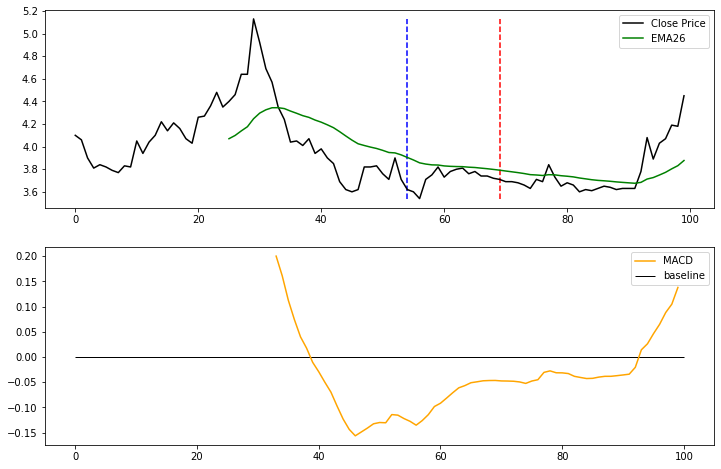

In [242]:
ema_period = 26
hk1119_ema = ta.EMA(hk1119_cp, timeperiod=ema_period)
period, score, pattern = compare_price_MACD(hk1119_cp, hk1119_macd, ema_period=ema_period, min_day=15)

print(period, score)
print(pattern)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

axes[0].plot(hk1119_cp, color='k', label="Close Price")
axes[0].plot(hk1119_ema, color='g', label="EMA26")
axes[0].vlines(period[0], hk1119_cp.min(), hk1119_cp.max(), color='b', linestyle='dashed')
axes[0].vlines(period[1], hk1119_cp.min(), hk1119_cp.max(), color='r', linestyle='dashed')
axes[0].legend(loc="upper right")

axes[1].plot(hk1119_macd, color='orange', label='MACD')
axes[1].hlines(0, 0, len(hk1119_macd), color='k', linewidth=1.0, label="baseline")
axes[1].legend(loc="upper right")

In [222]:
True!=False

True

In [162]:
hk1119_hp = get_high_price(hk1119_df, days=100)
hk1119_lp = get_low_price(hk1119_df, days=100)

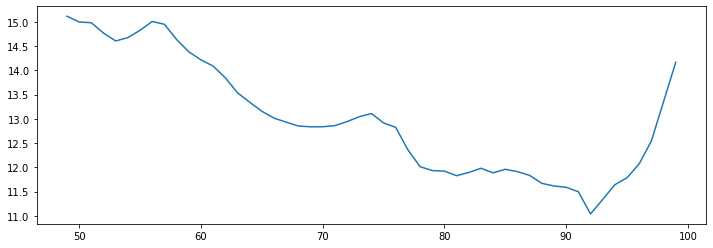

In [174]:
hk1119_dir = ta.ADX(hk1119_hp, hk1119_lp, hk1119_cp, timeperiod=25)
plt.plot(hk1119_dir)

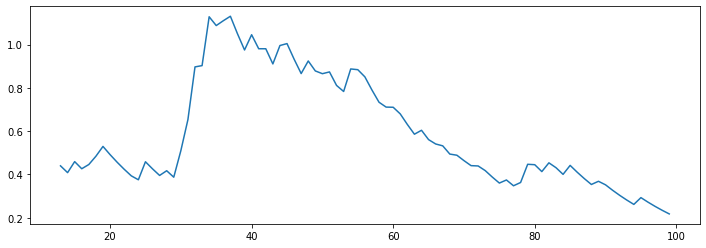

In [176]:
hk1119_mindm = ta.MINUS_DM(hk1119_hp, hk1119_lp, timeperiod=14)
plt.plot(hk1119_mindm)

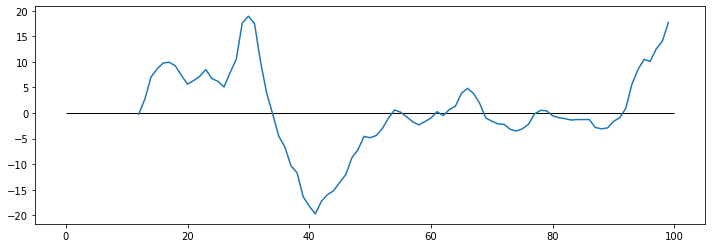

In [186]:
hk1119_roc = ta.MA(ta.ROC(hk1119_cp, timeperiod=10), timeperiod=3)
plt.hlines(0, 0, len(hk1119_roc), color='k', linewidth=1.0, label="baseline")
plt.plot(hk1119_roc)